In [1]:
import numpy as np
import trackpy as tp
import random
import pandas as pd
import skimage.measure
import matplotlib.pyplot as plt
import glob
import tifffile
from organoid_tracking import organoid_tracking

In [2]:
def test_make_organoid_masks(x,y,r,L):

    X,Y = np.ogrid[:L, :L]

    assert isinstance(x, list)
    assert isinstance(y, list)
    assert len(x) == len(y)

    test_image = np.zeros((L, L))

    for xn, yn, n in zip(x,y,range(len(x))):

        distance = np.sqrt((X-xn)**2 + (Y-yn)**2)
        test_image[distance<r] = n

    return test_image.astype(int)

def test_image():

    # number of organoids
    n = random.sample([1,2,3,4], 1)[0]
    L = 30

    # organoid positions
    r = 5
    x = random.sample(range(0, L), n)
    y = random.sample(range(0, L), n)
    
    test_image = test_make_organoid_masks(x,y,r,L)

    return test_image.astype(int)

def test_image_sequence():
    
    n = random.sample([10,11,12,13], 1)[0]
    
    return np.array([test_image() for  i in range(n)])

In [3]:
image = test_image()

check that the test images are correct:

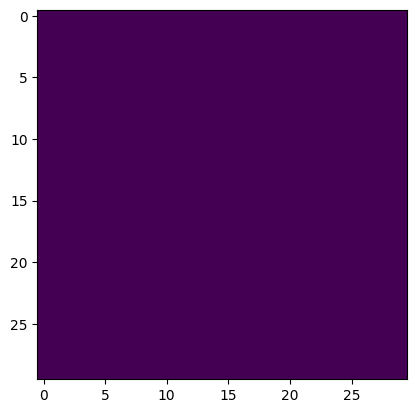

In [4]:
plt.imshow(image)

we verify that the information we get is relevant:

In [5]:
organoid_tracking.get_mask_properties(image)

,y,x,perimeter,area,label


## analyzing an image sequence

we get the organoid properties sequentially and then link the individual organoids together using trackpy.

In [6]:
def single_movie_trajs(image_sequence,
                       max_step = 50):

    """ From images sequences to trajectories """

    organoid_data = pd.DataFrame()

    for image, frame in zip(image_sequence, range(len(image_sequence))):
        
        properties = organoid_tracking.get_mask_properties(image)
        properties['frame'] = frame
        
        organoid_data = pd.concat([organoid_data, properties], 
                                ignore_index=True)

    organoid_data = tp.link(organoid_data, max_step, memory=3)

    return organoid_data

In [7]:
test_image_sequence = test_image_sequence()

In [8]:
path_to_imgs = '/Users/gustaveronteix/Documents/Code/Orakl/organoid_tracking/collective_ameobide/CNV029-Masks&DIC/Coll_CT-Stacks-masks'
fnames = glob.glob(os.path.join(path_to_imgs, '*.tiff'))

Frame 41: 3 trajectories present.


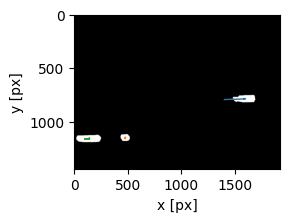

In [9]:
def get_particle_props(dataframe):

    for particle in dataframe.particle.unique():

        particleframe = dataframe[dataframe.particle == particle].copy()
        dataframe = dataframe.drop(dataframe[dataframe.particle == particle].index)

        particleframe['dx'] = particleframe.x - particleframe.x.shift()
        particleframe['dy'] = particleframe.y - particleframe.y.shift()
        particleframe['velocity'] = np.sqrt(particleframe.dx**2 + particleframe.dy**2)
        particleframe['cumulative_displacement'] = particleframe['velocity'].cumsum()

        xstart= particleframe.loc[particleframe.frame.idxmin(), 'x']
        ystart= particleframe.loc[particleframe.frame.idxmin(), 'y']

        particleframe['absolute_displacement'] = np.sqrt((particleframe.x - xstart)**2 + (particleframe.y - ystart)**2)

        dataframe = pd.concat([dataframe, particleframe])

    return dataframe

def movie_analysis(filename):

    movie_name, _ = filename.split('.')
    image_sequence = tifffile.imread(filename)

    # if spurious channels remove extra RGB one
    if image_sequence.ndim == 4:
        single_channel_image_sequence = image_sequence[..., 0]
        image_sequence = single_channel_image_sequence
        del(single_channel_image_sequence)

    # check that dimensions are OK
    assert image_sequence.ndim == 3

    movie_frame = single_movie_trajs(image_sequence,
                       max_step = 100)
    movie_frame = get_particle_props(movie_frame)
    movie_frame['movie_name'] = movie_name
    movie_frame['filename'] = filename

    plot_verification_image(movie_frame)

    return movie_frame

def plot_verification_image(movie_frame):

    directory = os.path.dirname(movie_frame.filename.unique()[0])
    mvname = os.path.basename(movie_frame.filename.unique()[0])
    mvname, _ = mvname.split('.')
    mvname += '.pdf'
    directory = os.path.join(directory, 'verification')

    if not os.path.exists(directory):
        os.makedirs(directory)

    image = tifffile.imread(movie_frame.filename.unique()[0])[0]

    fig, ax = plt.subplots(figsize=(4,2))
    plt.imshow(image)
    ax = tp.plot_traj(movie_frame)

    for particle in movie_frame.particle.unique():
        xtext = int(movie_frame.loc[(movie_frame.particle == particle), 'x'].mean())
        ytext = int(movie_frame.loc[(movie_frame.particle == particle), 'y'].mean())

        ax.text(x = xtext, y = ytext, s = str(particle), c = 'w', fontsize = 12)

    fig.savefig(os.path.join(directory, mvname))
    plt.close()
    
    return

movie_frames = map(movie_analysis, fnames)

file_data = pd.DataFrame()
file_data = pd.concat(list(movie_frames), 
                      ignore_index=True)
file_data['unique_organoid'] = file_data['particle'].astype(str) + ':' + file_data['movie_name']

In [11]:
organoid_statistics = pd.DataFrame(columns = ['movie_name', 'particle'])

for single_particle in file_data.unique_organoid.unique():

    unique_organoid_frame = file_data[file_data.unique_organoid == single_particle].sort_values('frame')
    
    assert len(unique_organoid_frame.movie_name.unique()) == 1
    assert len(unique_organoid_frame.particle.unique()) == 1

    single_organoid_statistics = pd.DataFrame(columns = ['movie_name',
                                                         'particle',
                                                         'unique_organoid',
                                                         'velocity_std',
                                                         'velocity_mean',
                                                         'perimeter',
                                                         'area',
                                                         'circularity'])

    single_organoid_statistics.loc[0, 'movie_name'] = unique_organoid_frame.movie_name.unique()[0]
    single_organoid_statistics.loc[0, 'particle'] = unique_organoid_frame.particle.unique()[0]
    single_organoid_statistics.loc[0, 'unique_organoid'] = single_particle

    single_organoid_statistics.loc[0, 'cumulative_displacement'] = unique_organoid_frame['cumulative_displacement'].max()
    single_organoid_statistics.loc[0, 'absolute_displacement'] = unique_organoid_frame.loc[unique_organoid_frame.index.max(), 'absolute_displacement']
    single_organoid_statistics.loc[0, 'velocity_std'] = unique_organoid_frame['velocity'].std()
    single_organoid_statistics.loc[0, 'velocity_mean'] = unique_organoid_frame['velocity'].mean()
    single_organoid_statistics.loc[0, 'perimeter'] = unique_organoid_frame['perimeter'].mean()
    single_organoid_statistics.loc[0, 'area'] = unique_organoid_frame['area'].mean()
    single_organoid_statistics.loc[0, 'circularity'] = 4*np.pi*(unique_organoid_frame['area']/unique_organoid_frame['perimeter']**2).mean()

    organoid_statistics = pd.concat([organoid_statistics, single_organoid_statistics])



In [12]:
savedir = '/Users/gustaveronteix/Documents/Code/Orakl/organoid_tracking/collective_ameobide/CNV029-Masks&DIC/'

organoid_statistics.to_csv(os.path.join(savedir, 'organoid_statistics.csv'), index = False)
file_data.to_csv(os.path.join(savedir, 'velocity_stats.csv'), index = False)